# 1.) Connecting the drive and Reading the files

In [7]:
# google drive imports
from google.colab import drive
# imports for running the assignment
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from scipy import signal
from  scipy import ndimage
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score, roc_auc_score, classification_report
import matplotlib.cm as cm

In [2]:
# Mount the drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# One can download the data from the following link 
# https://www.kaggle.com/keplersmachines/kepler-labelled-time-series-data
!unzip gdrive/My\ Drive/FINAL\ PROJECT\ DSCI\ 552/archive.zip > /dev/null # Dont show any output

In [4]:
train_df = pd.read_csv('archive/exoTrain.csv')
test_df = pd.read_csv('archive/exoTest.csv')
labels = train_df['LABEL'].values
train_df.head()

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,FLUX.10,FLUX.11,FLUX.12,FLUX.13,FLUX.14,FLUX.15,FLUX.16,FLUX.17,FLUX.18,FLUX.19,FLUX.20,FLUX.21,FLUX.22,FLUX.23,FLUX.24,FLUX.25,FLUX.26,FLUX.27,FLUX.28,FLUX.29,FLUX.30,FLUX.31,FLUX.32,FLUX.33,FLUX.34,FLUX.35,FLUX.36,FLUX.37,FLUX.38,FLUX.39,...,FLUX.3158,FLUX.3159,FLUX.3160,FLUX.3161,FLUX.3162,FLUX.3163,FLUX.3164,FLUX.3165,FLUX.3166,FLUX.3167,FLUX.3168,FLUX.3169,FLUX.3170,FLUX.3171,FLUX.3172,FLUX.3173,FLUX.3174,FLUX.3175,FLUX.3176,FLUX.3177,FLUX.3178,FLUX.3179,FLUX.3180,FLUX.3181,FLUX.3182,FLUX.3183,FLUX.3184,FLUX.3185,FLUX.3186,FLUX.3187,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,-160.17,-207.47,-154.88,-173.71,-146.56,-120.26,-102.85,-98.71,-48.42,-86.57,-0.84,-25.85,-67.39,-36.55,-87.01,-97.72,-131.59,-134.80,-186.97,-244.32,-225.76,-229.60,-253.48,-145.74,-145.74,30.47,-173.39,-187.56,-192.88,-182.76,...,-167.69,-56.86,7.56,37.40,-81.13,-20.10,-30.34,-320.48,-320.48,-287.72,-351.25,-70.07,-194.34,-106.47,-14.80,63.13,130.03,76.43,131.90,-193.16,-193.16,-89.26,-17.56,-17.31,125.62,68.87,100.01,-9.60,-25.39,-16.51,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,2,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,-73.38,-86.51,-74.97,-73.15,-86.13,-76.57,-61.27,-37.23,-48.53,-30.96,-8.14,-5.54,15.79,45.71,10.61,40.66,16.70,15.18,11.98,-203.70,19.13,19.13,19.13,19.13,19.13,17.02,-8.50,-13.87,-29.10,-34.29,...,-36.75,-15.49,-13.24,20.46,-1.47,-0.40,27.80,-58.20,-58.20,-72.04,-58.01,-30.92,-13.42,-13.98,-5.43,8.71,1.80,36.59,-9.80,-19.53,-19.53,-24.32,-23.88,-33.07,-9.03,3.75,11.61,-12.66,-5.69,12.53,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,484.39,469.66,462.30,492.23,441.20,483.17,481.28,535.31,554.34,562.80,540.14,576.34,551.67,556.69,550.86,577.33,562.08,577.97,530.67,553.27,538.33,527.17,532.50,273.66,273.66,292.39,298.44,252.64,233.58,171.41,...,-51.09,-33.30,-61.53,-89.61,-69.17,-86.47,-140.91,-84.20,-84.20,-89.09,-55.44,-61.05,-29.17,-63.80,-57.61,2.70,-31.25,-47.09,-6.53,14.00,14.00,-25.05,-34.98,-32.08,-17.06,-27.77,7.86,-70.77,-64.44,-83.83,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,2,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,323.33,311.14,326.19,313.11,313.89,317.96,330.92,341.10,360.58,370.29,369.71,339.00,336.24,319.31,321.56,308.02,296.82,279.34,275.78,289.67,281.33,285.37,281.87,88.75,88.75,67.71,74.46,69.34,76.51,80.26,...,-2.75,14.29,-14.18,-25.14,-13.43,-14.74,2.24,-31.07,-31.07,-50.27,-39.22,-51.33,-18.53,-1.99,10.43,-1.97,-15.32,-23.38,-27.71,-36.12,-36.12,-15.65,6.63,10.66,-8.57,-8.29,-21.90,-25.80,-29.86,7.42,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,2,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,-970.88,-933.30,-889.49,-888.66,-853.95,-800.91,-754.48,-717.24,-649.34,-605.71,-575.62,-526.37,-490.12,-458.73,-447.76,-419.54,-410.76,-404.10,-425.38,-397.29,-412.73,-446.49,-413.46,-1006.21,-1006.21,-973.29,-986.01,-975.88,-982.20,-953.73,...,-694.76,-705.01,-625.24,-604.16,-668.26,-742.18,-820.55,-874.76,-874.76,-853.68,-808.62,-777.88,-712.62,-694.01,-655.74,-599.74,-617.30,-602.98,-539.29,-672.71,-672.71,-594.49,-597.60,-560.77,-501.95,-461.62,-468.59,-513.24,-504.70,-521.95,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54


In [5]:
# Test set 
test_values = test_df.drop(columns=['LABEL']).values
test_labels = test_df['LABEL'].values
test_df.head()
test_labels

array([2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [8]:
# Checking the data distribution
print(Counter(test_labels))
print(Counter(labels))

Counter({1: 565, 2: 5})
Counter({1: 5050, 2: 37})


# 2.) Visualising the light intensity graphs

In [9]:
# Function display th graph
# the time is multiplied by 36 and divided by 60 to convert the minutes into hours as they are recorded in time intervals of 36 minutes.
def visualise_flux(flux,label):
  time = np.arange(len(flux)) * (36.0/60.0) 
  plt.figure(figsize=(15,5))
  if label == 1:
    plt.title(f'Plot of stars with no exoplanets with label {label} ')
  else:
    plt.title(f'Plot of stars with exoplanets with label {label} ')
  plt.ylabel('Flux, e-/s')
  plt.xlabel('Time, hours')
  plt.plot(time, flux)

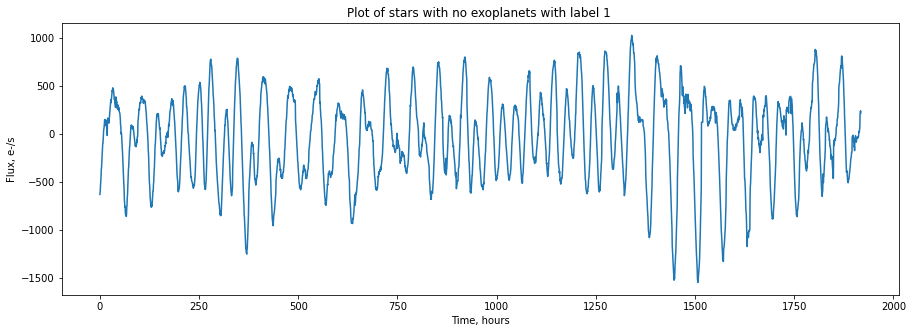

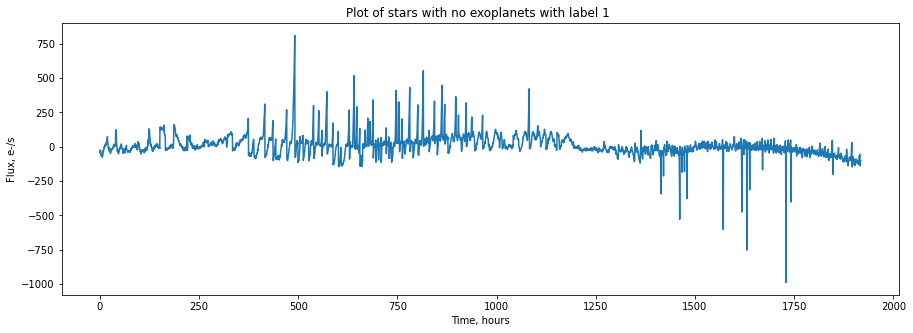

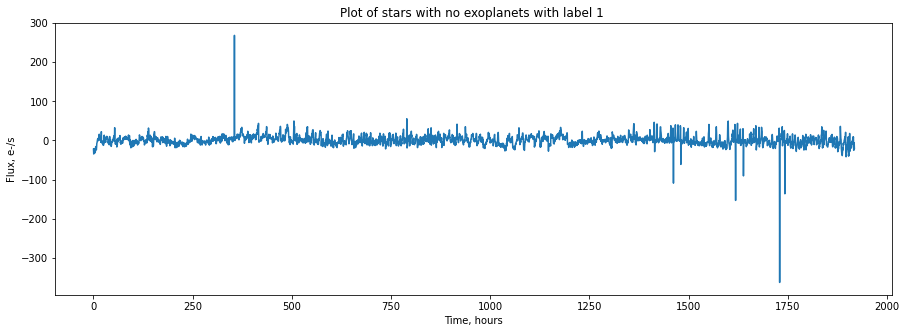

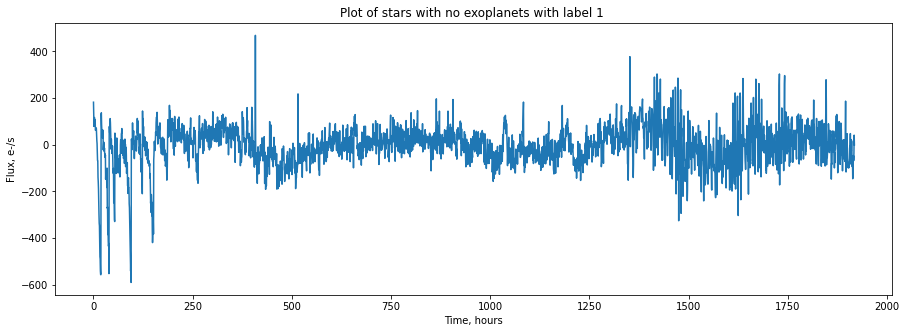

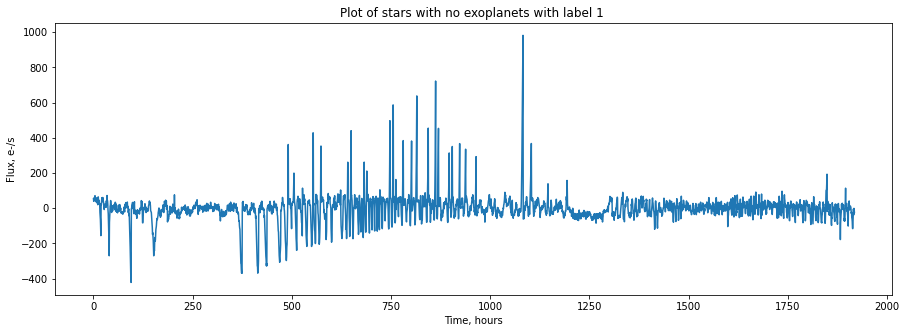

In [10]:
# Visualising the light intensity graphs of the stars that have no exo planets
for i in [50,60,70,80,90]:
    flux = train_df[train_df.LABEL == 1].drop('LABEL', axis=1).iloc[i,:]
    visualise_flux(flux,labels[i])

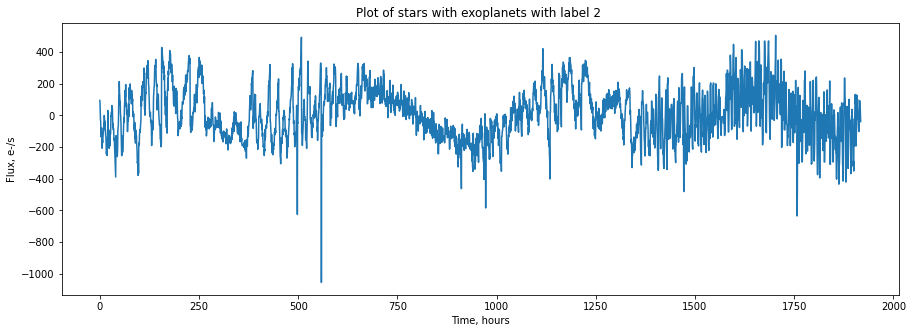

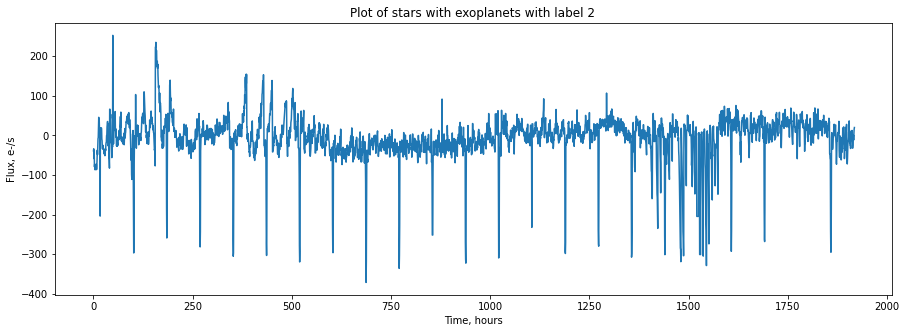

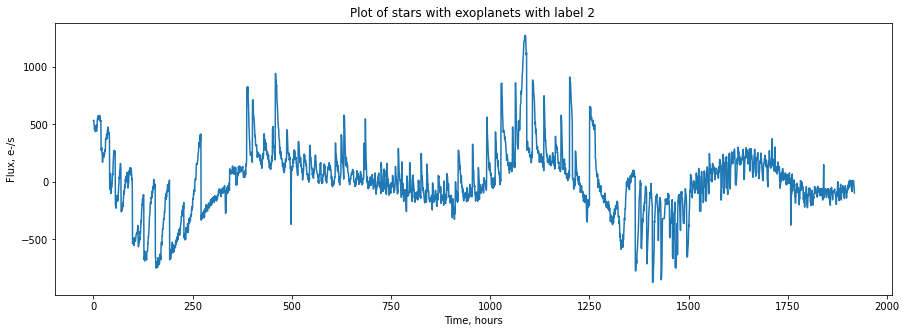

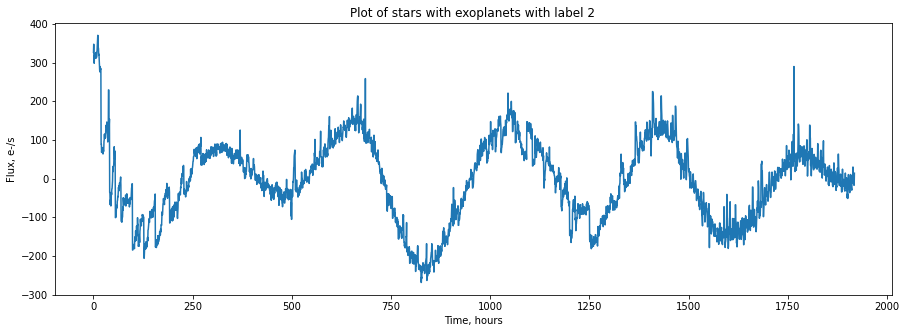

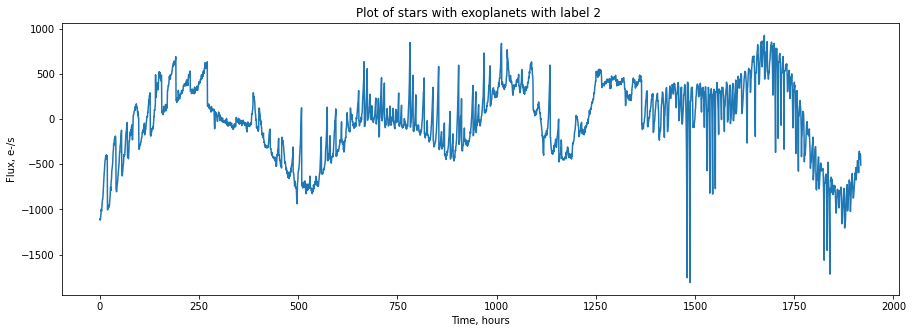

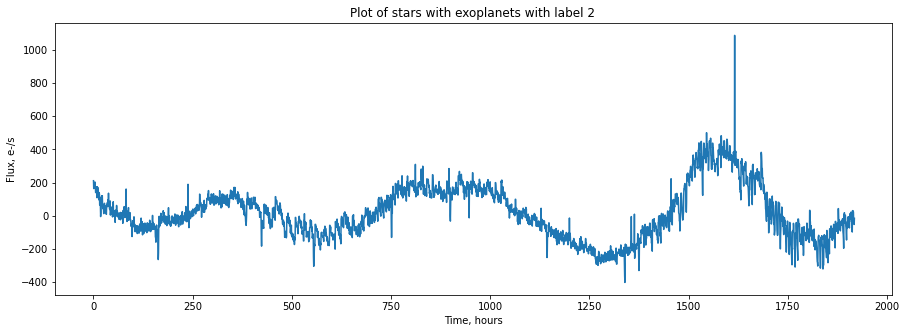

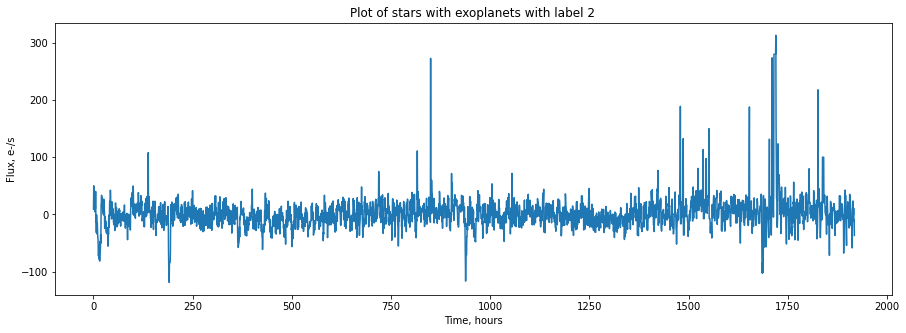

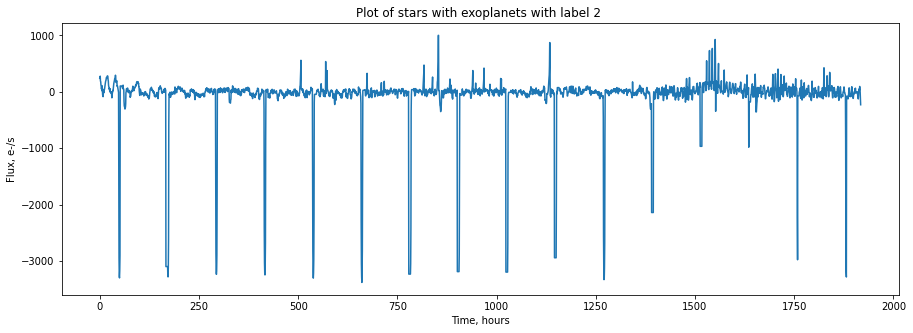

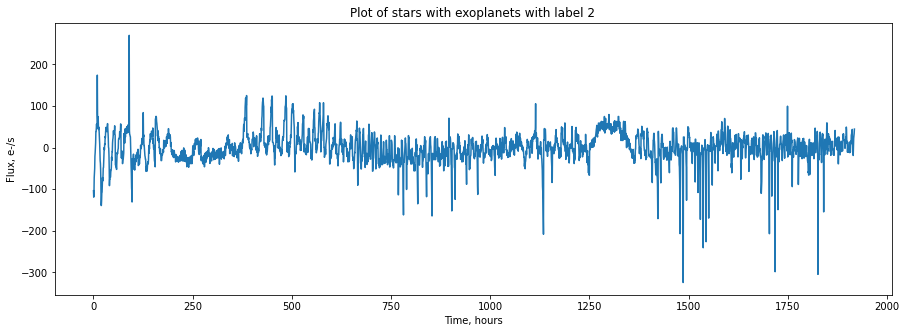

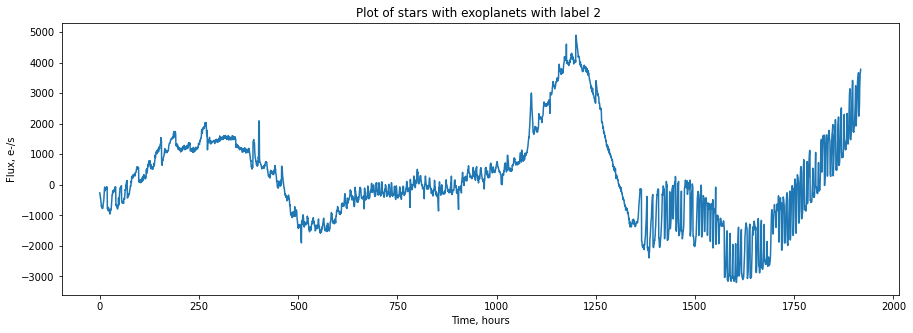

In [11]:
# Visualising the light intensity graphs of the stars that have exo planets
# the time is multiplied by 36 and divided by 60 to convert the minutes into hours as they are recorded in time intervals of 36 minutes.
for i in [0,1,2,3,4,5,6,7,8,9]:
    flux = train_df[train_df.LABEL == 2].drop('LABEL', axis=1).iloc[i,:]
    visualise_flux(flux,labels[i])

# 3.) Data Preprocessing and Data Augmentation 

Normalising the data 

Remove the upper outliers 

Smoothen the signals 

In [12]:
# Function to normalise the flux
def normalise(flux):
  n_flux = (flux - np.min(flux))/(np.max(flux)-np.min(flux))
  return n_flux

In [13]:
# Function to detrend the flux
# Applying the gausian filter to the image
# Taking the difference of the flux and the gausian filter to detrend data sigma is 7, it can be changed 
def detrend(flux,sigma = 7):
  d_flux = ndimage.filters.gaussian_filter(flux, sigma=sigma)
  return flux - d_flux

In [14]:
# Applying the all the functions in the pipeline 
# Train set
flux_values = train_df.drop(columns=['LABEL']).values
final_flux_values = []
for flux in flux_values:
  flux = normalise(flux)
  flux = detrend(flux)
  final_flux_values.append(flux)

np_test_values = []
for test in test_values:
  test = normalise(test)
  test = detrend(test)
  np_test_values.append(test)

np_test_values = np.array(np_test_values)

# Printing the values 
final_flux_values = np.array(final_flux_values)
final_flux_values.shape

(5087, 3197)

'Saved !'

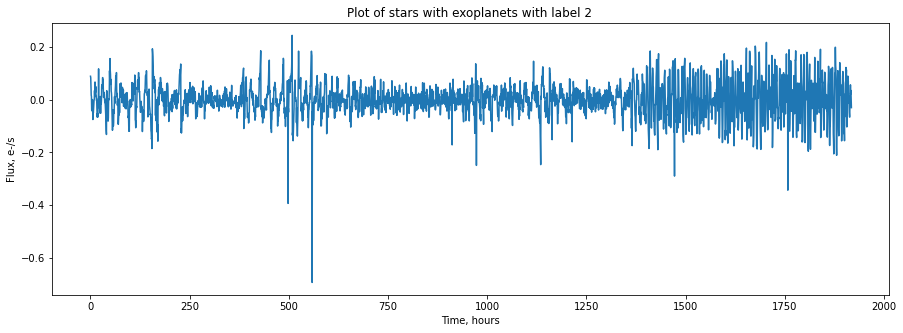

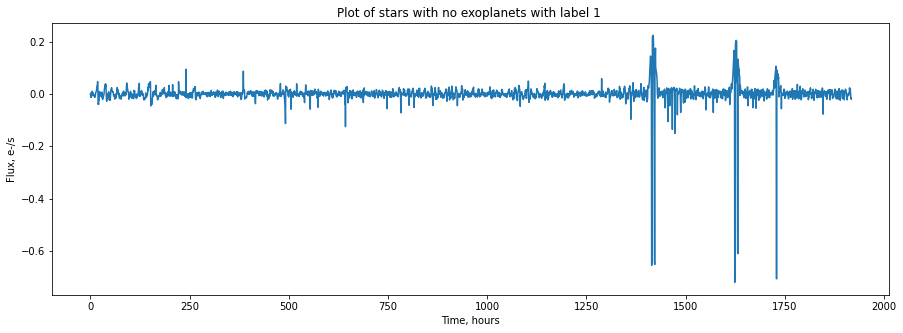

In [15]:
# Visualising some processed data 
visualise_flux(final_flux_values[0],labels[0])
visualise_flux(final_flux_values[100],labels[100])

# Saving the final_flux_values to the google drive
np.save('gdrive/MyDrive/FINAL PROJECT DSCI 552/processed_flux_data_v1.npy',final_flux_values)
display("Saved !")

# 4.) Clustering 

This is commented because it was giving very bad results, the code can be tested after uncommenting it.

In [13]:
# from sklearn.decomposition import PCA
# # Creating a PCA object to get the scree plot
# pca = PCA() # create a PCA object
# pca.fit(final_flux_values) # do the math
# pca_data = pca.transform(final_flux_values)

# per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
# labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]
# plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
# plt.ylabel('Percentage of Explained Variance')
# plt.xlabel('Principal Component')
# plt.title('Scree Plot')
# plt.show()

In [14]:
# var = 0.99
# pca = PCA(n_components=var)
# X_reduced = pca.fit_transform(final_flux_values)
# X_reduced.shape

In [15]:
# visualise_flux(final_flux_values[0],0)

In [16]:
# visualise_flux(X_reduced[0],0)

In [17]:
# # This function is copied from the official website of sklearn
# # https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
# # It is slightly modified to be used in the problem set.

# for n_clusters in [2]:
#     # Creating a figure 
#     fig, ax1 = plt.subplots()
#     fig.set_size_inches(18, 7)

#     ax1.set_xlim([-0.1, 1])
#     ax1.set_ylim([0, len(X_reduced) + (n_clusters + 1) * 10])

#     # seed of 13 for reproducibility.
#     clusterer = KMeans(n_clusters=n_clusters, random_state=13)
#     cluster_labels = clusterer.fit_predict(X_reduced)

#     # Finding the silhoutte score 
#     silhouette_avg = silhouette_score(X_reduced, cluster_labels)
#     print("For n_clusters =", n_clusters,
#           "The average silhouette_score is :", silhouette_avg)

#     # Compute the silhouette scores for each sample
#     sample_silhouette_values = silhouette_samples(X_reduced, cluster_labels)

#     y_lower = 10
#     for i in range(n_clusters):
#         # Aggregate the silhouette scores for samples belonging to
#         # cluster i, and sort them
#         ith_cluster_silhouette_values = \
#             sample_silhouette_values[cluster_labels == i]

#         ith_cluster_silhouette_values.sort()

#         size_cluster_i = ith_cluster_silhouette_values.shape[0]
#         y_upper = y_lower + size_cluster_i

#         color = cm.nipy_spectral(float(i) / n_clusters)
#         ax1.fill_betweenx(np.arange(y_lower, y_upper),
#                           0, ith_cluster_silhouette_values,
#                           facecolor=color, edgecolor=color, alpha=0.7)

#         # Label the silhouette plots with their cluster numbers at the middle
#         ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

#         # Compute the new y_lower for next plot
#         y_lower = y_upper + 10  # 10 for the 0 samples

#     ax1.set_title(f"The silhouette plot for the {n_clusters} number of  clusters.")
#     ax1.set_xlabel("The silhouette coefficient values")
#     ax1.set_ylabel("Cluster label")

#     # The vertical line for average silhouette score of all the values
#     ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

#     ax1.set_yticks([])  # Clear the yaxis labels / ticks
#     ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


# # 7 gives best silhoutte score, choosing 7 as the number of cluster

# 5.) SMOTE 

In [16]:
from imblearn.over_sampling import SMOTE
from collections import Counter
oversample = SMOTE(ratio =0.7)

new_flux_values,new_labels = oversample.fit_resample(final_flux_values,labels)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [17]:
new_flux_values.shape

(8585, 3197)

In [18]:
new_labels.shape

(8585,)

In [19]:
counter = Counter(new_labels)
counter

Counter({1: 5050, 2: 3535})

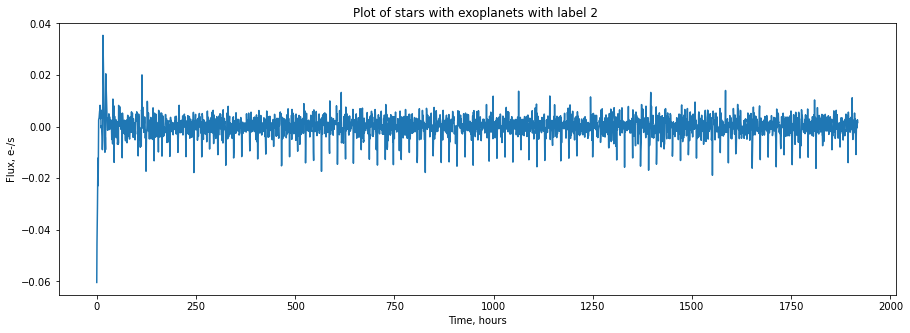

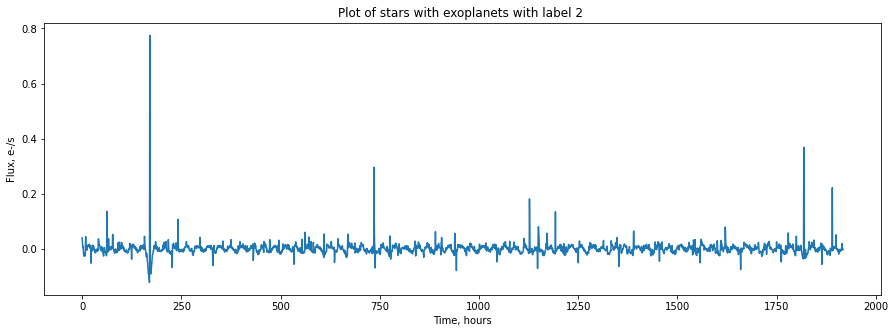

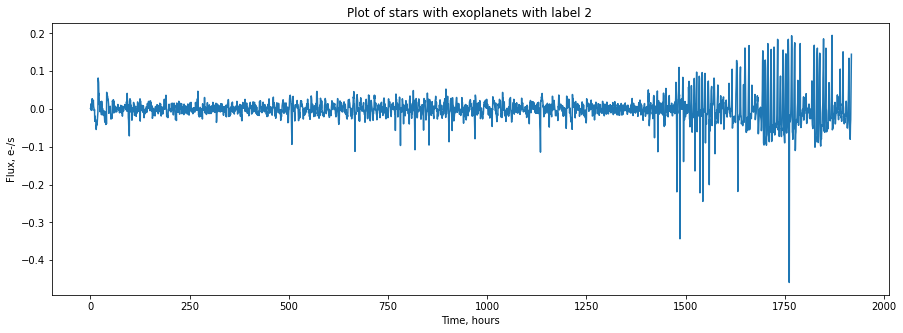

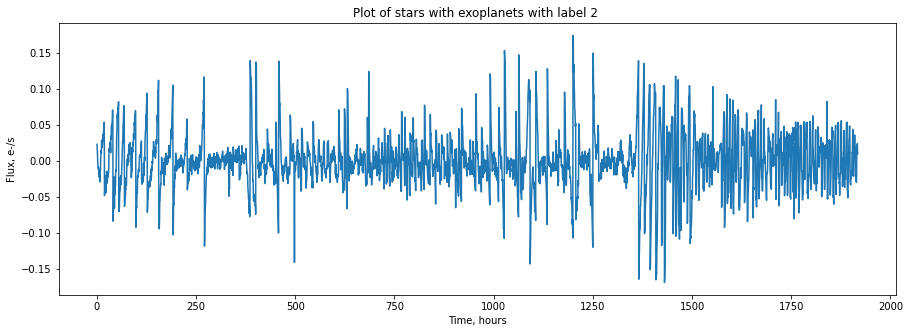

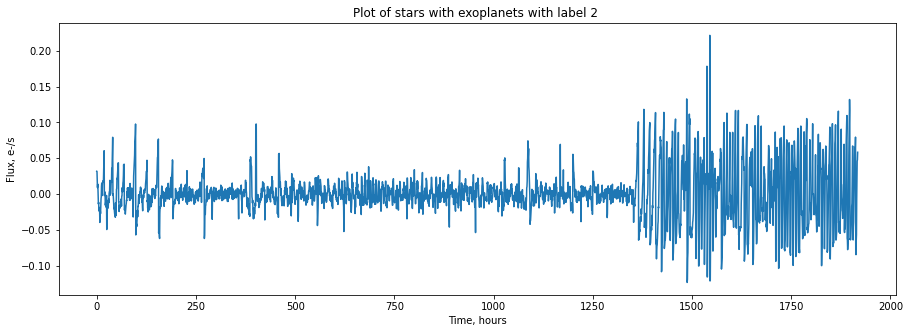

In [20]:
for k in range(len(labels),len(labels)+5):
  visualise_flux(new_flux_values[k],new_labels[k])

In [21]:
final_flux_values.shape

(5087, 3197)

# 6.) Models 

KNN

XgBoost

Neural Network 

Convulational Neural Network 

Recurrent Neural Network 


In [22]:
scores = []
train_y = new_labels - 1
test_y = test_labels - 1
Counter(train_y)

Counter({0: 5050, 1: 3535})

In [23]:
from sklearn.neighbors import KNeighborsClassifier

Knn = KNeighborsClassifier(n_neighbors=3)
Knn.fit(new_flux_values,train_y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [24]:
predict_values = Knn.predict(test_values)

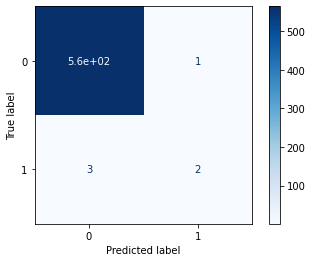

In [25]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
plot_confusion_matrix(Knn,test_values,test_y.reshape(-1,1),cmap=plt.cm.Blues)

In [26]:
predict_values_prob = Knn.predict_proba(test_values)

In [27]:
predict_values_prob

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [28]:
roc_auc_score(test_labels,predict_values)
scores.append(roc_auc_score(test_labels,predict_values))

In [29]:
from xgboost import XGBClassifier
xgb = XGBClassifier(scale_pos_weight=5050/37)
# xgb = XGBClassifier()
xgb.fit(new_flux_values,train_y)
y_xgb = xgb.predict(test_values)

In [30]:
cm = confusion_matrix(test_y, y_xgb)
print(cm)

[[565   0]
 [  5   0]]


In [31]:
print(classification_report(test_y,y_xgb))
scores.append(roc_auc_score(test_y,y_xgb))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       565
           1       0.00      0.00      0.00         5

    accuracy                           0.99       570
   macro avg       0.50      0.50      0.50       570
weighted avg       0.98      0.99      0.99       570



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [32]:
new_flux_values.shape
train_y.shape

(8585,)

In [33]:
# The CNN model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Reshape, Dense, Dropout, Conv1D, MaxPooling1D, Flatten
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.optimizers.schedules import ExponentialDecay
from keras.models import load_model


model = Sequential()
model.add(Reshape((3197, 1), input_shape=(3197,)))
model.add(Conv1D(filters=10, kernel_size=2, activation='tanh', input_shape=(3197, 1), kernel_regularizer='l2'))
model.add(MaxPooling1D(pool_size=2, strides=2))
model.add(Conv1D(filters=10, kernel_size=2, activation='tanh', kernel_regularizer='l2'))
model.add(MaxPooling1D(pool_size=2, strides=2))
model.add(Flatten())
model.add(Dense(48, activation="tanh"))
model.add(Dropout(0.4))
model.add(Dense(18, activation="tanh"))
model.add(Dense(1, activation="sigmoid"))

lr_schedule = ExponentialDecay(initial_learning_rate=1e-2, decay_steps=10000, decay_rate=0.94)

model.compile(optimizer = Adam(learning_rate=lr_schedule), loss='binary_crossentropy', metrics=['accuracy','AUC'])


history = model.fit(new_flux_values, train_y ,validation_data=(test_values,test_y) , epochs=15, verbose=2)


Epoch 1/15
269/269 - 35s - loss: 0.7031 - accuracy: 0.5815 - auc: 0.4878 - val_loss: 0.5970 - val_accuracy: 0.9912 - val_auc: 0.5000
Epoch 2/15
269/269 - 1s - loss: 0.6814 - accuracy: 0.5846 - auc: 0.5044 - val_loss: 0.5586 - val_accuracy: 0.9912 - val_auc: 0.5000
Epoch 3/15
269/269 - 1s - loss: 0.6804 - accuracy: 0.5871 - auc: 0.4973 - val_loss: 0.5345 - val_accuracy: 0.9912 - val_auc: 0.5000
Epoch 4/15
269/269 - 1s - loss: 0.6813 - accuracy: 0.5840 - auc: 0.5026 - val_loss: 0.4607 - val_accuracy: 0.9912 - val_auc: 0.5000
Epoch 5/15
269/269 - 1s - loss: 0.6810 - accuracy: 0.5882 - auc: 0.4916 - val_loss: 0.6102 - val_accuracy: 0.9912 - val_auc: 0.5000
Epoch 6/15
269/269 - 1s - loss: 0.6820 - accuracy: 0.5858 - auc: 0.4967 - val_loss: 0.4752 - val_accuracy: 0.9912 - val_auc: 0.5000
Epoch 7/15
269/269 - 1s - loss: 0.6807 - accuracy: 0.5882 - auc: 0.4991 - val_loss: 0.5204 - val_accuracy: 0.9912 - val_auc: 0.5000
Epoch 8/15
269/269 - 1s - loss: 0.6805 - accuracy: 0.5882 - auc: 0.5000 - v

In [ ]:
# model.save("gdrive/MyDrive/FINAL PROJECT DSCI 552/best_cnn_model")

In [34]:
# This is the mdodel with pretrained weights
import keras
model2 = keras.models.load_model('gdrive/MyDrive/FINAL PROJECT DSCI 552/best_cnn_model')

In [35]:
model2.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_15 (Reshape)         (None, 3197, 1)           0         
_________________________________________________________________
conv1d_30 (Conv1D)           (None, 3196, 10)          30        
_________________________________________________________________
max_pooling1d_30 (MaxPooling (None, 1598, 10)          0         
_________________________________________________________________
conv1d_31 (Conv1D)           (None, 1597, 10)          210       
_________________________________________________________________
max_pooling1d_31 (MaxPooling (None, 798, 10)           0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 7980)              0         
_________________________________________________________________
dense_45 (Dense)             (None, 48)              

In [36]:
predict_y = model2.predict(test_values)

In [37]:
scores.append(roc_auc_score(test_y,predict_y))
roc_auc_score(test_y,predict_y)

0.8313274336283186

In [38]:
predict_y = list(predict_y)

predict_y_list = []
for p in predict_y:
  if p > 0.53:
    predict_y_list.append(1)
  else:
    predict_y_list.append(0)
  
predict_y_list = np.array(predict_y_list)

In [39]:
predict_y_list

array([0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,

In [40]:
confusion_matrix(test_y,predict_y_list)

array([[533,  32],
       [  2,   3]])

In [41]:
# Simple Neural Network
model = keras.Sequential()
# model.add(Reshape((3197, 1), input_shape=(3197,)))
model.add(keras.layers.InputLayer(input_shape=(3197,)))
model.add(keras.layers.Dense(units=1024, activation='relu'))
model.add(keras.layers.Dense(units=512, activation='relu'))
model.add(keras.layers.Dense(units=32, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.compile(optimizer = Adam(), loss='binary_crossentropy', metrics=['accuracy','AUC'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 1024)              3274752   
_________________________________________________________________
dense_4 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_5 (Dense)              (None, 32)                16416     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 3,816,001
Trainable params: 3,816,001
Non-trainable params: 0
_________________________________________________________________


In [42]:
history = model.fit(new_flux_values, train_y ,validation_data=(test_values,test_y) , epochs=15, verbose=2)

Epoch 1/15
269/269 - 2s - loss: 0.0312 - accuracy: 0.9901 - auc: 0.9994 - val_loss: 2778.0647 - val_accuracy: 0.9912 - val_auc: 0.5000
Epoch 2/15
269/269 - 1s - loss: 0.0013 - accuracy: 0.9997 - auc: 1.0000 - val_loss: 4013.5293 - val_accuracy: 0.9895 - val_auc: 0.4991
Epoch 3/15
269/269 - 1s - loss: 1.3045e-04 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 4141.0957 - val_accuracy: 0.9895 - val_auc: 0.4991
Epoch 4/15
269/269 - 1s - loss: 2.5116e-05 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 4148.5664 - val_accuracy: 0.9895 - val_auc: 0.4991
Epoch 5/15
269/269 - 1s - loss: 1.2522e-05 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 4159.3242 - val_accuracy: 0.9895 - val_auc: 0.4991
Epoch 6/15
269/269 - 1s - loss: 7.7502e-06 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 4172.0020 - val_accuracy: 0.9877 - val_auc: 0.4982
Epoch 7/15
269/269 - 1s - loss: 5.3061e-06 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 4185.3716 - val_accuracy: 0.9877 - val_auc: 0.4982
Epoch 8/15
269/269 - 1s - loss: 3.8

In [43]:
simple_y = model.predict(test_values)
scores.append(roc_auc_score(test_y,simple_y))

In [ ]:
# Recurrent Neural Network
# This is unfinished and takes too long to run
# Hence this is commented. Can be worked upon

# model = keras.Sequential()
# model.add(Reshape((3197, 1), input_shape=(3197,)))
# model.add(keras.layers.LSTM(
#   units=100,
#   input_shape=(3197, 1),
#   return_sequences = True
# ))
# model.add(keras.layers.LSTM(
#   units=50,
#   return_sequences = True
# ))
# model.add(Flatten())
# # model.add(Dense(64,activation = 'relu'))
# model.add(keras.layers.Dense(units=1,activation='sigmoid'))

# model.summary()


In [ ]:
# model.compile(
#   loss='binary_crossentropy',
#   optimizer=keras.optimizers.Adam(0.001),
#   metrics=['accuracy','AUC']
# )
# history = model.fit(new_flux_values, train_y ,validation_data=(test_values,test_y) , epochs=10, verbose=2)

In [44]:
scores_name = ["KNN","XgBoost","Convulational Neural Network","Simple Neural Network"]

In [45]:
scores_df = pd.DataFrame(zip(scores_name,scores),columns = ["Name","AUC"])

In [46]:
scores_df

,Name,AUC
0,KNN,0.699115
1,XgBoost,0.500000
2,Convulational Neural Network,0.831327
3,Simple Neural Network,0.498230
